In [68]:
import os, sys
import numpy as np
from os.path import dirname
import pandas as pd
from numba import njit
from tqdm import tqdm
import h5py, pystan
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

# Read-in and Clean Data

In [69]:
df = pd.read_csv('two_step_data.txt')

In [70]:
df_copy = df.copy()
gd = df_copy.groupby('subject')

In [71]:
# retain subjects with less than 20% of data missing
f = df_copy.groupby('subject').filter(lambda x: x.stage_1_choice.isnull().mean() <= 0.2)

In [72]:
# retain subjects with reasonable reaction times
f = f.groupby('subject').filter(lambda x: np.logical_and(x.stage_1_rt < 2.5, x.stage_1_rt > 0.2).mean() >= 0.8)

In [73]:
f

,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
0,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,1,0.743,0.273,0.717,0.479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,2,0.714,0.290,0.712,0.456,1.0,0.444,1.0,1.0,2.0,1.566,1.0
2,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,3,0.709,0.346,0.714,0.466,1.0,0.459,0.0,1.0,3.0,0.669,1.0
3,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,4,0.732,0.339,0.704,0.386,1.0,0.409,1.0,1.0,2.0,0.491,1.0
4,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,5,0.717,0.408,0.722,0.422,1.0,0.356,1.0,1.0,2.0,0.574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341994,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,196,0.384,0.712,0.479,0.387,1.0,0.449,0.0,1.0,3.0,0.507,1.0
341995,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,197,0.373,0.734,0.460,0.375,1.0,0.132,1.0,1.0,2.0,0.432,1.0
341996,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,198,0.440,0.748,0.461,0.410,1.0,0.838,0.0,1.0,3.0,0.430,1.0
341997,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,199,0.471,0.737,0.468,0.375,1.0,0.406,0.0,1.0,3.0,0.396,0.0


In [74]:
f['stage_1_choice'] = f['stage_1_choice'] - 1
f['stage_2_choice'] = f['stage_2_choice'] - 1
f['stage_2_state'] = f['stage_2_state'] - 2

In [75]:
f

,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
0,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,1,0.743,0.273,0.717,0.479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,2,0.714,0.290,0.712,0.456,0.0,0.444,1.0,0.0,0.0,1.566,1.0
2,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,3,0.709,0.346,0.714,0.466,0.0,0.459,0.0,0.0,1.0,0.669,1.0
3,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,4,0.732,0.339,0.704,0.386,0.0,0.409,1.0,0.0,0.0,0.491,1.0
4,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,5,0.717,0.408,0.722,0.422,0.0,0.356,1.0,0.0,0.0,0.574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341994,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,196,0.384,0.712,0.479,0.387,0.0,0.449,0.0,0.0,1.0,0.507,1.0
341995,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,197,0.373,0.734,0.460,0.375,0.0,0.132,1.0,0.0,0.0,0.432,1.0
341996,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,198,0.440,0.748,0.461,0.410,0.0,0.838,0.0,0.0,1.0,0.430,1.0
341997,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,199,0.471,0.737,0.468,0.375,0.0,0.406,0.0,0.0,1.0,0.396,0.0


In [76]:
# retain subjects with reasonable choices
f = f.groupby('subject').filter(lambda x: np.logical_and(x.stage_1_choice.mean() > 0.05, x.stage_1_choice.mean() < 0.95))


In [77]:
subs = f['subject'].unique()

In [78]:
data = []
for s in subs:
    subdata = f.loc[f['subject'] == s]
    
    r = subdata['outcome']
    Y1 = subdata['stage_1_choice'] - 1
    t = subdata['transition']

    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    sub_list = np.array([s] * len(prev_R))
    
    g = DataFrame(np.column_stack([sub_list, prev_R, prev_T, stay]))
    data.append(g)
    
data = DataFrame(np.concatenate(data), columns=['subject','prev_R', 'prev_T', 'Stay'])

In [80]:
data

,subject,prev_R,prev_T,Stay
0,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
1,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
2,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
3,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
4,304SM51WA34XCM4E67SL28LY2UCBS4,0.0,0.0,0
...,...,...,...,...
280385,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,0.0,0.0,1
280386,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1
280387,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,1.0,1
280388,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1


In [81]:
subjects = data['subject'].unique()

# Posterior Predictive Check

In [82]:
import os, pystan
import _pickle as pickle

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [83]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA.stan'

## Sampling parameters.
samples = 2000
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 44750

In [84]:
## Load StanModel
StanModel = load_model(PATH_NAME)

In [85]:
EA_data = []
for s in subjects:
    # Find subject and fix issues
    dat = f.loc[f['subject'] == s]
    dat = dat.dropna()
    dat = dat[dat.outcome != -1.0]
    
    # set data values for Stan
    r = dat['outcome'].astype(int)
    Y1 = dat['stage_1_choice'].astype(int)
    Y2 = dat['stage_2_choice'].astype(int)
    S2 = dat["stage_2_state"].astype(int)
    t = dat['transition'].astype(int)
    T = len(dat)
    
    ## Assemble data.
    dd = dict(T=T, Y1=Y1, Y2=Y2, S2=S2, R=r)
    
    ## Fit model.
    StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)
    
    w = StanFit.extract('w')['w'].mean()
    beta_1 = StanFit.extract('beta1')['beta1'].mean()
    beta_2 = StanFit.extract('beta2')['beta2'].mean()
    eta_1  = StanFit.extract('eta1')['eta1'].mean()
    eta_2  = StanFit.extract('eta2')['eta2'].mean()
    
    g = DataFrame(np.column_stack([s, w, beta_1, beta_2, eta_1, eta_2]))
    EA_data.append(g)

KeyboardInterrupt: 

In [33]:
EAd = pd.DataFrame(np.concatenate(EA_data), columns=['subject','weight', 'beta1', 'beta2', 'eta1', 'eta2'])
EAd

,subject,weight,beta1,beta2,eta1,eta2
0,30MVJZJNHMDLPQ6RLT5BJ1ZLJ01J96,0.5000529682955799,0.3957386254142981,1.6923247067661296,0.48146742675210896,0.19777658406326432
1,30MVJZJNHMDLPQ6RLT5BJ1ZLJ5TJ98,0.6799639081147932,9.489194000126743,1.6901532478197807,0.05138516582055971,0.22591482668314483
2,30OG32W0SUBY3COT82DP4MHDI9XNEI,0.5864985810429738,2.02019925253285,1.8745857870838232,0.23308966317136748,0.2215467793732192
3,30OG32W0SUBY3COT82DP4MHDIENNEI,0.5287379008782985,1.511426138717436,3.289167100008195,0.24463456777060946,0.13641608396507923
4,30OG32W0SUBY3COT82DP4MHDJHQNES,0.5996883731810764,1.2054296543441698,1.2177605172783357,0.2439223322745355,0.2654070063104744
5,30X31N5D63QSTCZM0TSP7X1SKJRSA4,0.5188190937267887,1.0750989901271446,3.4612195234246848,0.34194501620353845,0.16147078629177322
6,30X31N5D63QSTCZM0TSP7X1SL2TASR,0.5680288071790265,1.1026424332142046,2.552105978572,0.3023118435035093,0.1645701784497777
7,30X31N5D63QSTCZM0TSP7X1SL5SSAE,0.5738539700163726,2.01757414388557,1.9381115131215416,0.27667328111043626,0.2529730707760408
8,30ZX6P7VF8VAP6LS0KQW9ER7CCNJ29,0.4584152342121696,2.794678809527375,3.242312985319718,0.1569975189865666,0.1253579465076766
9,30ZX6P7VF8VAP6LS0KQW9ER7DUH2JN,0.09228360061652417,3.1656136412877043,4.182155702155651,0.22381855555260757,0.12405443539164025


In [34]:
## Define inv_logit function
def inv_logit(x):
    return 1. / (1. + np.exp(-x))

In [35]:
class EA(object):
    
    def __init__(self, b1, b2, eta1, eta2, w):
        
        ## Define parameters.
        self.b1 = b1
        self.b2 = b2
        self.eta1 = eta1
        self.eta2 = eta2
        self.w = w
        
        ## Initialize Q-values.
        self.Qs1 = None
        self.Qs2 = None
        
    def train(self, drifts, reset=False):
        
        ## Error-catching: rewards.
        ##drifts = np.array(drifts)
        
        ## Initialize Q-values.
        if self.Qs1 is None or reset:
            self.Qs1 = 0.5 * np.ones(2)
        
        if self.Qs2 is None or reset:
            self.Qs2 = 0.5 * np.ones((2,2))
            
        ## Preallocate space.
        n_trials = drifts.shape[0]    
        Y1, Y2, S2, t, r = np.zeros((5,n_trials), dtype=int)
        Y_pred = np.zeros((n_trials), dtype=float)
            
        for i in range(n_trials):

            theta1 = inv_logit( self.b1 * (self.Qs1[1] - self.Qs1[0]))
            
            ## Stage 1: Simulate choice.
            Y1[i] = np.random.binomial(1,theta1)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S2[i] = np.where(t[i], Y1[i], 1-Y1[i])
                        
            ## Stage 2: Compute choice likelihood.
            theta2 = inv_logit( self.b2 * (self.Qs2[S2[i],1] - self.Qs2[S2[i],0]) )
            
            ## Stage 2: Simulate choice.
            Y2[i] = np.random.binomial(1,theta2)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S-1,Y[i,1]]
            r[i] = np.random.binomial(1, drifts[i, S2[i], Y2[i]])
            
            ## Update stage 2 Q-values
            self.Qs2[S2[i], Y2[i]] += self.eta2 * (r[i] - self.Qs2[S2[i], Y2[i]])
            # where's eta1 in all this?
            
            if t[i]: cr = 0.7  # common transition
            else: cr = 0.3     # rare transition
            
            ## Update Stage 1 Q-values
            # Chosen action
            deltaC = r[i] - self.Qs1[Y1[i]]
            self.Qs1[Y1[i]] += self.eta1 * (self.w * cr * deltaC + (1 - self.w) * deltaC)
            
            # Unchosen action
            deltaU = r[i] - self.Qs1[1 - Y1[i]]
            self.Qs1[1-Y1[i]] += self.eta1 * self.w * (1-cr) * deltaU
            
            ## Get predictive density
            Y_pred[i] = np.where(Y1[i], theta1, 1-theta1)
            
        return Y1, Y2, S2, t, r, Y_pred

In [36]:
EA_subs = EAd['subject']

In [37]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

## Iterate through subjects
total1 = []
total2 = []
for s in EA_subs:
    i = EAd[EAd['subject'] == s].index
    
    w = float(EAd.iloc[i].weight)
    beta_1 = float(EAd.iloc[i].beta1)
    beta_2 = float(EAd.iloc[i].beta2)
    eta_1 = float(EAd.iloc[i].eta1)
    eta_2 = float(EAd.iloc[i].eta2)
    
    data1 = []
    data2 = []
    ## Iterate through trials
    for _ in tqdm(range(T)):
    
        ## Initialize agent.
        agent = EA(b1 = beta_1, b2 = beta_2, eta1 = eta_1, eta2 = eta_2, w = w)

        ## Train agent.
        Y1, Y2, S2, t, r, Y_pred = agent.train(drifts)
    
        ## Define variables.
        prev_R = np.roll(r, 1)[1:].astype(int)
        prev_T = np.roll(t, 1)[1:].astype(int)
        Stay = Y1[:-1] == Y1[1:]
        Stay = Stay.astype(int)
        sub_list1 = np.array([s] * len(prev_R))
        sub_list2 = np.array([s] * len(Y1))
        
        g1 = DataFrame(np.column_stack([sub_list1, prev_R, prev_T, Stay]))
        g2 = DataFrame(np.column_stack([sub_list2, Y1, Y_pred]))
        data1.append(g1)
        data2.append(g2)
    
    data1 = pd.DataFrame(np.concatenate(data1), columns=['subject','prev_R', 'prev_T', 'Stay'])
    data2 = pd.DataFrame(np.concatenate(data2), columns=['subject','Y1', 'Y_pred'])
    total1.append(data1)
    total2.append(data2)
    pred_stays = pd.concat(total1)
    pred_probs = pd.concat(total2)

100%|██████████| 201/201 [00:02<00:00, 89.24it/s]


In [38]:
## Get Simulated Metrics
sim_metrics = []
uq_subs = pred_probs['subject'].unique()
for s in uq_subs:
    sd = pred_stays.loc[pred_stays['subject'] == s]
    
    # P(stay | rewarded (R=1), common (T=1))
    g1 = np.array(sd.loc[(sd['prev_R'] == '1') & (sd['prev_T'] == '1'), 'Stay'], dtype=int).mean()
    # P(stay | rewarded (R=1), uncommon (T=0))
    g2 = np.array(sd.loc[(sd['prev_R'] == '1') & (sd['prev_T'] == '0'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), common (T=1))
    g3 = np.array(sd.loc[(sd['prev_R'] == '0') & (sd['prev_T'] == '1'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), uncommon (T=0))
    g4 = np.array(sd.loc[(sd['prev_R'] == '0') & (sd['prev_T'] == '0'), 'Stay'], dtype=int).mean()
    
    metric = (g1 - g2) - (g3- g4)
    sim_metrics.append(metric)

In [39]:
sim_metrics

[0.019266760567404784,
 0.06851036535671662,
 0.06743740356297895,
 0.056624759994264084,
 0.04785804226391199,
 0.014741187953679069,
 0.036465639454500154,
 0.05909167737401699,
 0.05809753831559644,
 0.03942471316075091]

In [41]:
real_subs = subjects

In [42]:
data

,subject,prev_R,prev_T,Stay
0,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
1,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
2,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
3,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
4,304SM51WA34XCM4E67SL28LY2UCBS4,0.0,0.0,0
...,...,...,...,...
280385,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,0.0,0.0,1
280386,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1
280387,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,1.0,1
280388,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1


In [45]:
## Get Corresponding Real Participant Metrics
par_metrics = []
for s in real_subs:
    sd = data.loc[data['subject'] == s]
    
    # P(stay | rewarded (R=1), common (T=1))
    g1 = np.array(sd.loc[(sd['prev_R'] == '1.0') & (sd['prev_T'] == '1.0'), 'Stay'], dtype=int).mean()
    # P(stay | rewarded (R=1), uncommon (T=0))
    g2 = np.array(sd.loc[(sd['prev_R'] == '1.0') & (sd['prev_T'] == '0.0'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), common (T=1))
    g3 = np.array(sd.loc[(sd['prev_R'] == '0.0') & (sd['prev_T'] == '1.0'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), uncommon (T=0))
    g4 = np.array(sd.loc[(sd['prev_R'] == '0.0') & (sd['prev_T'] == '0.0'), 'Stay'], dtype=int).mean()
    
    metric = (g1 - g2) - (g3- g4)
    par_metrics.append(metric)

In [46]:
par_metrics

[0.18479994452534498,
 -0.00564958377717284,
 0.009805220999250797,
 0.40020743145743143,
 -0.03320330015245265,
 0.3023391812865498,
 0.33666666666666667,
 -0.2288839373297544,
 0.7249641148325359,
 0.015798989383895012]

Text(0, 0.5, 'Real Participant Metrics')

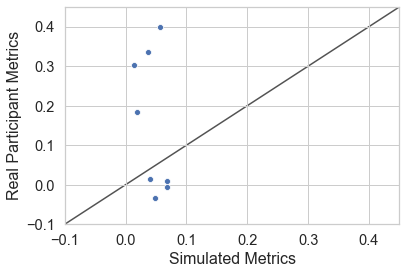

In [67]:
sns.set_style("whitegrid")
ax = sns.scatterplot(sim_metrics, par_metrics)
lims = [-0.1, 0.45]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Simulated Metrics')
ax.set_ylabel('Real Participant Metrics')